## Tutorial of adding / substracting activations to any stream

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/Adding%20activations%20to%20any%20stream.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "10/06/2023"

### Overview

Interventions have many types: (1) activation swapping, (2) activation addition, or (3) any other kind of operations that modify the activation. Some of them modify the addition respecting to its original basis, some do not. In this tutorial, we show how can we do any kind of activation modification using this library.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("..")

import torch
import pandas as pd
from models.utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import AdditionIntervention, SubstractionIntervention
from models.gpt2.modelings_alignable_gpt2 import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10

### Factual recall with our alignable module directly

In [4]:
def activation_addition_position_config(model_type, intervention_type, n_layer):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                i,                 # layer
                intervention_type, # intervention type
                "pos",             # intervention unit
                1                  # max number of unit
            ) for i in range(n_layer)
        ],
        alignable_interventions_type=AdditionIntervention,
    )
    return alignable_config
config, tokenizer, gpt = create_gpt2()

Some weights of the model checkpoint at gpt2 were not used when initializing GPT2Model: ['h.2.attn.bias', 'h.9.attn.bias', 'h.6.attn.bias', 'h.10.attn.bias', 'h.7.attn.bias', 'h.1.attn.bias', 'h.3.attn.bias', 'h.4.attn.bias', 'h.8.attn.bias', 'h.11.attn.bias', 'h.5.attn.bias', 'h.0.attn.bias']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


loaded model


In [5]:
alignable_config = activation_addition_position_config(type(gpt), "mlp_output", gpt.config.n_layer)

alignable = AlignableModel(alignable_config, gpt)

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
print(base)
res = alignable(inputs[0])[0]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = alignable(inputs[1])[0]
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
_Madrid              0.1050141304731369
_the                 0.09496939927339554
_Barcelona           0.07027813792228699
_a                   0.04010074958205223
_now                 0.02824239805340767
_in                  0.027599532157182693
_Spain               0.022991584613919258
_Catalonia           0.018822969868779182
_also                0.018689032644033432
_not                 0.017356548458337784

The capital of Italy is
_Rome                0.15734830498695374
_the                 0.07316426932811737
_Milan               0.04687758535146713
_a                   0.03449871018528938
_now                 0.03200360760092735
_in                  0.02306593582034111
_also                0.022748040035367012
_home                0.019202154129743576
_not                 0.01640518754720688
_Italy               0.015770938247442245


### We add a word embedding to all MLP streams at the last position
In other tutorials, we often pass in `sources` where each of the example is drawn from the training data. Another way to do patching is, instead of passing in real input example, we pass in activations. These activations can be designed off-line in some particular ways.

In [6]:
# we can patch mlp with the rome word embedding
rome_token_id = tokenizer(" Rome")["input_ids"][0]
rome_embedding = gpt.wte(torch.tensor(rome_token_id)).clone().unsqueeze(0).unsqueeze(0) # make it a fake batch
activations_sources = dict(
    zip(alignable.sorted_alignable_keys, 
        [rome_embedding]*len(alignable.sorted_alignable_keys))
)
# we intervene on all of the mlp output
alignable.sorted_alignable_keys

['layer.0.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.1.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.2.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.3.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.4.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.5.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.6.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.7.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.8.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.9.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.10.repr.mlp_output.unit.pos.nunit.1#0',
 'layer.11.repr.mlp_output.unit.pos.nunit.1#0']

In [8]:
base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt"),
    tokenizer(source, return_tensors="pt")
]
_, counterfactual_outputs = alignable(
    inputs[0],
    unit_locations={"sources->base": ([[[0]]]*gpt.config.n_layer, [[[4]]]*gpt.config.n_layer)}, # last position
    activations_sources=activations_sources
)
distrib = embed_to_distrib(
    gpt, counterfactual_outputs.last_hidden_state, 
    logits=False
)
top_vals(tokenizer, distrib[0][-1], n=10)

_Rome                0.45583686232566833
_Madrid              0.278819739818573
_Barcelona           0.10827570408582687
_Valencia            0.01563052088022232
_Lisbon              0.00841545220464468
_the                 0.006678536534309387
_Santiago            0.006526666227728128
_Naples              0.004116411320865154
_Florence            0.003120462642982602
_Athens              0.0028584988322108984


If you are interested by this work, you can simply think token embeddings at each layer are moved toward the token `_Rome` via the activation addition. Obviouosly, the LM head (which is tied with the embedding matrix) is going to pick out the most similar vectors, which are `_Rome` at the end, and some other countries since they are close to `_Rome`.

You can also read more about this in this paper: [Language Models Implement Simple Word2Vec-style Vector Arithmetic](https://arxiv.org/abs/2305.16130).

### Let's have a more systematic analysis of the addition effect of MLP and MHA streams
We add the word embedding till the `i`-th layer of these streams

In [9]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")
base = tokenizer("The capital of Spain is", return_tensors="pt")

data = []
for till_layer_i in range(gpt.config.n_layer):
    alignable_config = activation_addition_position_config(type(gpt), "mlp_output", till_layer_i+1)
    alignable = AlignableModel(alignable_config, gpt)
    activations_sources = dict(
        zip(alignable.sorted_alignable_keys, 
            [rome_embedding]*len(alignable.sorted_alignable_keys))
    )
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            unit_locations={"sources->base": ([[[0]]]*(till_layer_i+1), [[[pos_i]]]*(till_layer_i+1))},
            activations_sources=activations_sources
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"f{till_layer_i}",
                'pos': pos_i,
                'type': "mlp_output"
            })
            
    alignable_config = activation_addition_position_config(type(gpt), "attention_output", till_layer_i+1)
    alignable = AlignableModel(alignable_config, gpt)
    activations_sources = dict(
        zip(alignable.sorted_alignable_keys, 
            [rome_embedding]*len(alignable.sorted_alignable_keys))
    )
    
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = alignable(
            base,
            unit_locations={"sources->base": ([[[0]]]*(till_layer_i+1), [[[pos_i]]]*(till_layer_i+1))},
            activations_sources=activations_sources
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, 
            logits=False
        )
        for token in tokens:
            data.append({
                'token': format_token(tokenizer, token),
                'prob': float(distrib[0][-1][token]),
                'layer': f"a{till_layer_i}",
                'pos': pos_i,
                'type': "attention_input"
            })
df = pd.DataFrame(data)

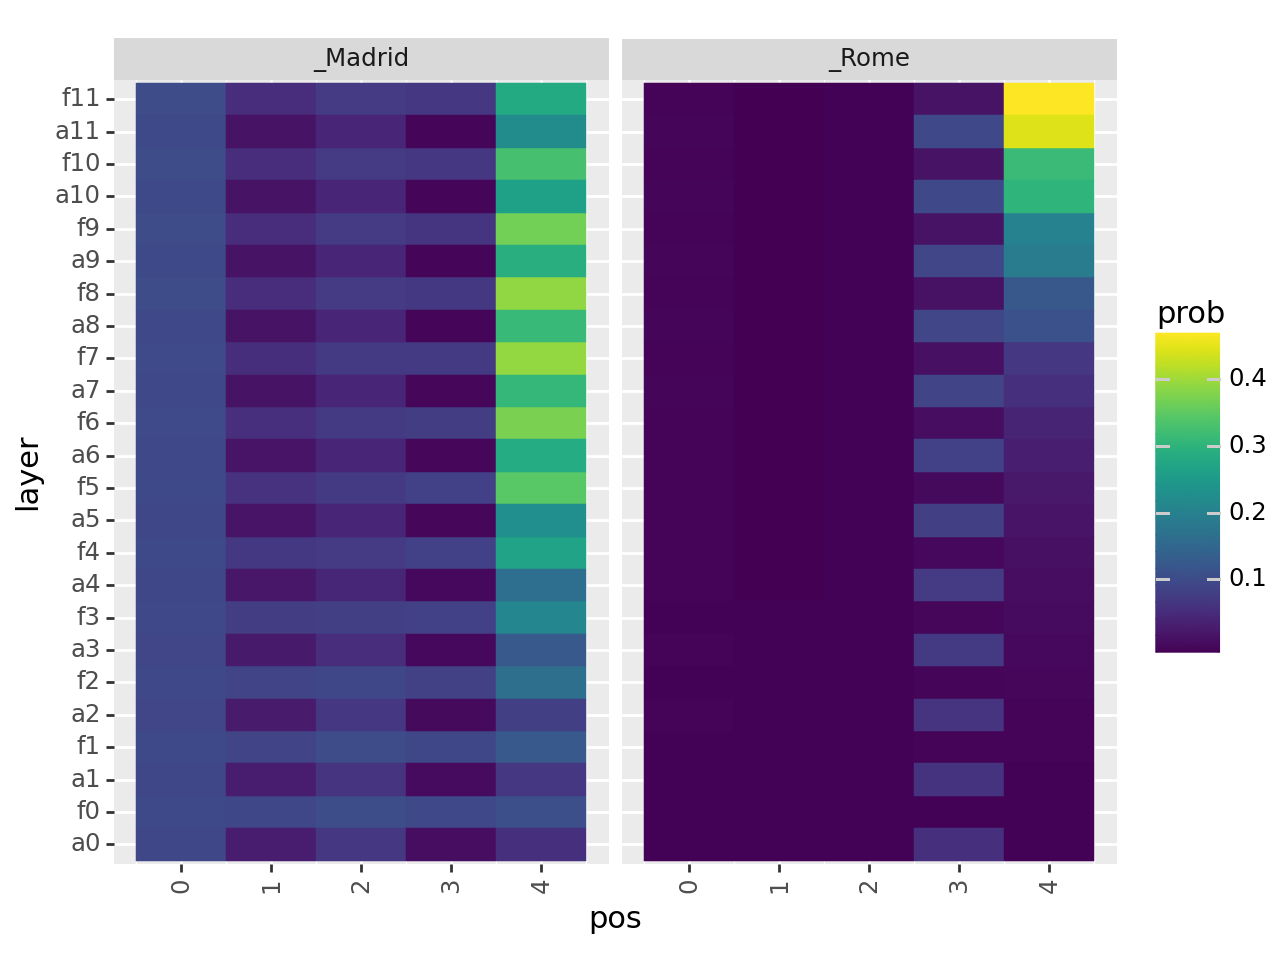

In [11]:
df['layer'] = df['layer'].astype('category')
df['token'] = df['token'].astype('category')
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f'f{l}')
    nodes.append(f'a{l}')
df['layer'] = pd.Categorical(df['layer'], categories=nodes[::-1], ordered=True)

g = (ggplot(df) + geom_tile(aes(x='pos', y='layer', fill='prob', color='prob')) +
     facet_wrap("~token") + theme(axis_text_x=element_text(rotation=90)))
print(g)